# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [8]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [9]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [10]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1, name="DL1")
    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2, name="DL2")
    # Вихідний шар
    self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes, name="EL")


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer_1(x)
    x = self.layer_2(x)
    return self.layer_3(x, activation=tf.nn.softmax)

In [11]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Приведення  y_true до float32
    y_true = tf.cast(y_true, tf.float32)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Приведення  y_true до float32
    y_true = tf.cast(y_true, tf.float32)

    y_pred_labels = tf.argmax(y_pred, axis=1)
    y_pred_labels = tf.cast(y_pred_labels, tf.float32)

    correct_predictions = tf.equal(y_pred_labels, y_true)
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [12]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
    # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
    #optimizer = tf.optimizers.SGD(learning_rate)
    optimizer = tf.optimizers.Adam(learning_rate)

    # Активація автоматичного диференціювання
    with tf.GradientTape() as g:
      pred = neural_net(input_x)
      loss = cross_entropy(pred, output_y)

      # Отримаємо список оптимізованих параметрів
      trainable_vars = neural_net.trainable_variables
      # Обчислимо за ними значення градієнта
      gradients = g.gradient(loss, trainable_vars)

      # Модифікуємо параметри
      optimizer.apply_gradients(zip(gradients, trainable_vars))
    return loss

In [19]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    loss = train(neural_net, batch_x, batch_y)
    if step % display_step == 0:
        pred = neural_net(batch_x)
        current_loss = cross_entropy(pred, batch_y)
        accur = accuracy(pred, batch_y)
        accuracy_history.append(accur)
        loss_history.append(current_loss)
        print(f"Step {step:4}, Loss: {current_loss:7.2f}, Accuracy: {accur:.2%}")
        if accur > 0.99:
          print("Break by accuracy")
          break

Step  100, Loss:   19.37, Accuracy: 97.27%
Step  200, Loss:   35.55, Accuracy: 95.31%
Step  300, Loss:   23.57, Accuracy: 98.44%
Step  400, Loss:   20.96, Accuracy: 97.27%
Step  500, Loss:   17.28, Accuracy: 98.05%
Step  600, Loss:   13.11, Accuracy: 97.66%
Step  700, Loss:   12.84, Accuracy: 98.83%
Step  800, Loss:   34.57, Accuracy: 97.27%
Step  900, Loss:   18.35, Accuracy: 98.83%
Step 1000, Loss:   10.93, Accuracy: 98.05%
Step 1100, Loss:    6.58, Accuracy: 99.61%
Break by accuracy


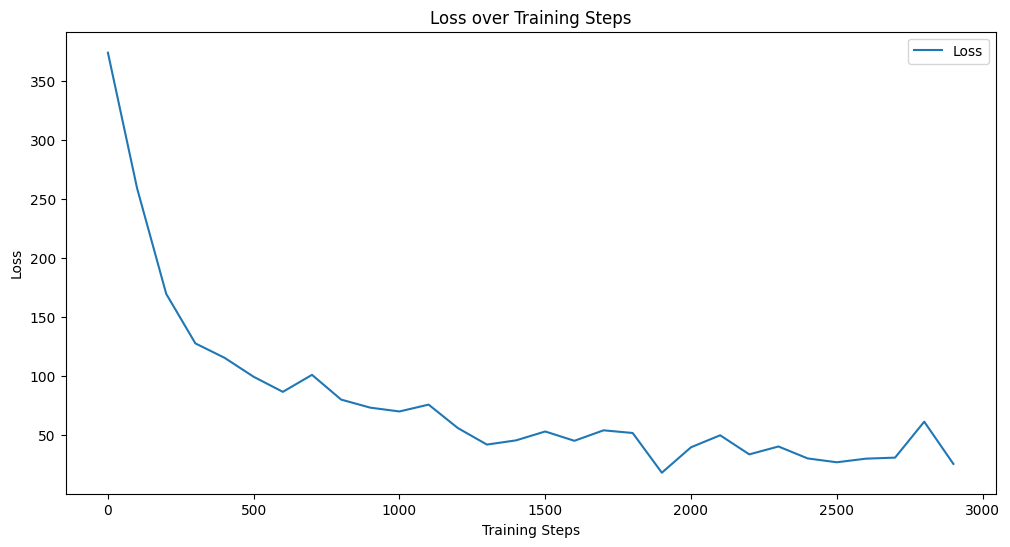

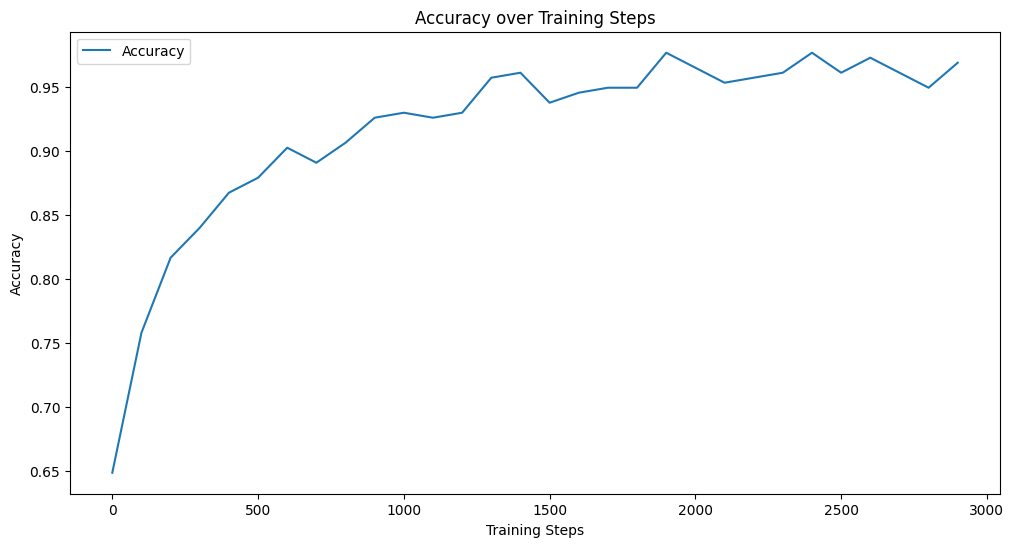

In [14]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.figure(figsize=(12, 6))
plt.plot(range(0, training_steps, display_step), loss_history, label='Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Loss over Training Steps')
plt.legend()
plt.show()

# Виведіть графік точності
plt.figure(figsize=(12, 6))
plt.plot(range(0, training_steps, display_step), accuracy_history, label='Accuracy')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.title('Accuracy over Training Steps')
plt.legend()
plt.show()


In [15]:
# Обчисліть точність навченої нейромережі
acc_mean = np.mean(accuracy_history)
print(f"{acc_mean=:%}")
# Тестування моделі на тестових даних
test_pred = neural_net(x_test)
test_acc = accuracy(test_pred, y_test).numpy()
test_pred_values = np.argmax(test_pred, axis=1)
print(f"{test_acc=:%}")
# Тестування моделі на тестових даних
testing_select = 10
test_pred = neural_net(x_test[:testing_select])
test_acc = accuracy(test_pred, y_test[:testing_select]).numpy()
print(f"{testing_select=}, test_acc_{testing_select}={test_acc:.2%}")

acc_mean=91.731769%
test_acc=93.480003%
testing_select=10, test_acc_10=100.00%


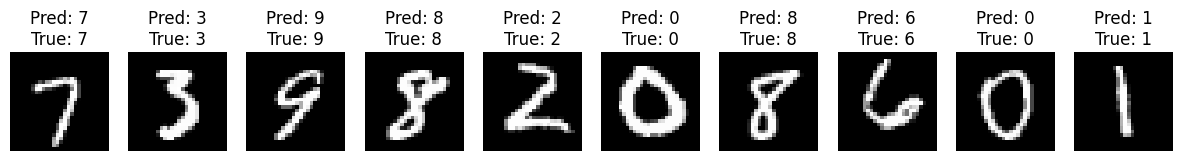

In [20]:
import matplotlib.pyplot as plt
import numpy as np

image_count = 10

# Беремо  image_count випадкових  індексів з x_test
random_indices = np.random.choice(len(x_test), image_count, replace=False)

# Вибираємо наші image_count випадкових   зображень та їхні мітки
random_images = x_test[random_indices]
true_labels = y_test[random_indices]

# Переволими зображення в формат  изображения в формат 28x28
reshaped_images = random_images.reshape(-1, 28, 28)

# Знаходимо predictions для вибраних зображень
predictions = neural_net(random_images)
predicted_labels = np.argmax(predictions, axis=1)

# ВВізуалізуємо зображення та їхні передбачення
plt.figure(figsize=(15, 7))
for i in range(image_count):
    plt.subplot(1, image_count, i + 1)
    plt.imshow(reshaped_images[i], cmap='gray')
    plt.title(f"Pred: {predicted_labels[i]}\nTrue: {true_labels[i]}")
    plt.axis('off')

plt.show()




In [17]:
from sklearn.metrics import classification_report

target_names = [f"Number: {i}" for i in range(num_classes)]
print(classification_report(y_test, test_pred_values, target_names=target_names))

cr = classification_report(y_test, test_pred_values, target_names=target_names, output_dict=True)
print(f"Accuracy: {cr['accuracy']:.4f}")

              precision    recall  f1-score   support

   Number: 0       0.96      0.97      0.97       980
   Number: 1       0.98      0.98      0.98      1135
   Number: 2       0.94      0.93      0.93      1032
   Number: 3       0.91      0.91      0.91      1010
   Number: 4       0.94      0.93      0.94       982
   Number: 5       0.92      0.90      0.91       892
   Number: 6       0.95      0.96      0.96       958
   Number: 7       0.95      0.93      0.94      1028
   Number: 8       0.88      0.91      0.90       974
   Number: 9       0.91      0.92      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

Accuracy: 0.9348


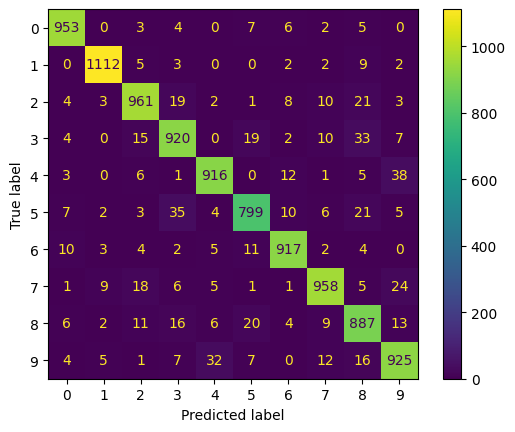

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, test_pred_values  )
plt.show()